# <center> CS559 Homework#3: Decision Tree and Ensemble Methods</center>
## <center> Due: 11/8/2021 Monday at 11:59 PM</center>


In this assignment, you are going to implement four classifiers - **decision tree, random forest, adaboost, and gradient boost**. 
Then check the performance with `sklearn` built-in algorithms.
In this work, splitting into train and test sets is not necessary. 

The provided data has four columns - three features (a, b, and c) and the target (class). Three features are continuous data and the target is a binary, 0 or 1. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./F21_CS559_HW3_data.csv')

In [3]:
df.head(5)

,a,b,c,class
0,9.4202,-4.3507,10.3764,1
1,9.7044,-4.4601,10.6803,1
2,9.8075,-4.0894,10.6259,1
3,9.2771,-4.0349,10.1166,1
4,9.6447,-3.5968,10.2936,1


In [4]:
print("Shape:",df.shape)
print("num samples =",df.shape[0])
print("num attributes =",df.shape[1])

Shape: (2500, 4)
num samples = 2500
num attributes = 4


In [5]:
df.dtypes

a        float64
b        float64
c        float64
class      int64
dtype: object

In [6]:
df.describe()

,a,b,c,class
count,2500.000000,2500.000000,2500.000000,2500.0000
mean,-0.008806,-2.985478,6.280229,1.5004
std,4.824436,3.415397,2.097566,0.5001
min,-7.393200,-8.952900,2.231800,1.0000
25%,-4.132175,-5.379600,4.519050,1.0000
50%,-0.911990,-3.268200,6.645050,2.0000
75%,4.595575,-0.621515,7.628075,2.0000
max,9.823100,5.387800,10.693600,2.0000


In [7]:
df['class'].value_counts() 

2    1251
1    1249
Name: class, dtype: int64

In [8]:
df.nunique()

a        2482
b        2470
c        2455
class       2
dtype: int64

In [9]:
df.isna().sum()

a        0
b        0
c        0
class    0
dtype: int64

Our dataset is clean so we can start making our classifiers

### Question 1: Decisition Tree Classifier
- A simple DT implementation (10 pts.)
    - to make the problem simple, implement a decision tree with depth of 3 (the root index is 0).
    - calculate the gini index for each attribute and pick the best attribute for each node.
    - calculate the accuracy using accuracy score. 
- Classification using DecistionTreeClassifier (5 pts)
- Evaluation (5 pts)

In [10]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

In [11]:
class MyDecisionTreeClassifier():
    def __init__(self):
         
        self.root = None
        
        # stopping condition at depth of 3
        self.max_depth = 3
        self.entropy_total = None
        
    def build_tree(self, X, Y, curr_depth=0):
               
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met i.e at depth of 3
        if curr_depth <= self.max_depth:
            best_split = self.pick_best_attribute_split(X, Y, num_samples, num_features)
            if best_split!={}:
                
                # recursion for left subtree
                left_subtree = self.build_tree(best_split["X_left"],best_split["Y_left"], curr_depth+1)

                # recursion for right subtree
                right_subtree = self.build_tree(best_split["X_right"],best_split["Y_right"], curr_depth+1)

                return Node(best_split["feature_index"], best_split["threshold"], left_subtree, right_subtree, best_split["info_gain"]) 
    
        leaf_value = self.get_best_leaf_value(Y)
        
        return Node(value=leaf_value)
    
    def pick_best_attribute_split(self, X, Y, num_samples, num_features):
        
        best_split = {}
        max_info_gain = -float("inf")
        
        for feature_index in range(num_features):
            
            feature_values = X[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            
            for threshold in possible_thresholds:
                
                X_left, X_right, y_left, y_right = self.split(X, Y, feature_index, threshold)
         
                if len(X_left)>0 and len(X_right)>0:
                    
                    curr_info_gain = self.information_gain(Y, y_left, y_right)
        
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["X_left"] = X_left
                        best_split["Y_left"] = y_left
                        best_split["X_right"] = X_right
                        best_split["Y_right"] = y_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        return best_split
    
    def split(self, X, Y, feature_index, threshold):
        
        dataset = np.concatenate((X, Y.reshape(-1,1)), axis=1)
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold],dtype=np.int64)
        
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold],dtype=np.int64)
        
        if len(dataset_left)==0:
            X_left = dataset_left
            y_right = dataset_left
        else:
            X_left = dataset_left[:, :-1]
            y_left = dataset_left[:, -1]
            
        if len(dataset_right)==0:
            X_right = dataset_right
            y_right = dataset_right
        else:
            X_right = dataset_right[:, :-1]
            y_right = dataset_right[:, -1]
        
        return X_left, X_right, y_left, y_right
    
    def entropy(y):
        hist = np.bincount(y)
        p = hist / len(y)
        entropy = -np.sum([p * np.log(p) for p in p if p > 0]) #log of negative vale is not possible
        return entropy
    
    def information_gain(self, parent, l_child, r_child):
        
        prob_l = len(l_child) / len(parent)
        prob_r = len(r_child) / len(parent)
        
        gain = self.gini_index(parent) - (prob_l*self.gini_index(l_child) + prob_r*self.gini_index(r_child))
        
        return gain
    
    def gini_index(self, y):
        n = np.unique(y)
        gini = 0
        for i in n:
            gini += np.square((len(y[y == i]) / len(y)))
            
        return 1 - gini
        
    def get_best_leaf_value(self, Y):
        classes = np.bincount(Y)
        return np.argmax(classes)
    
    def print_tree(self, tree=None, indent=" "):
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        
        self.root = self.build_tree(X, Y)
    
    def predict(self, X):
        
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        
        
        if tree.value!=None:
            return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [12]:
from sklearn.model_selection import train_test_split
X = df[['a','b','c']].values
y = df['class'].values.reshape(-1,1)

In [13]:
tree = MyDecisionTreeClassifier()
tree.fit(X,y)
tree.print_tree()

X_2 <= 6.2893 ? 0.3351670315688118
 left:X_0 <= -4 ? 0.024805246330136033
  left:X_0 <= -6 ? 0.0
    left:1
    right:X_0 <= -5 ? 0.0
        left:1
        right:1
  right:X_0 <= -3 ? 0.0
    left:X_1 <= -1 ? 0.0
        left:2
        right:2
    right:X_0 <= -2 ? 0.0
        left:2
        right:2
 right:X_0 <= 5 ? 0.11856273917181956
  left:X_0 <= 4 ? 0.0019619810612307425
    left:X_0 <= -7 ? 0.0
        left:1
        right:1
    right:X_1 <= -6 ? 0.2627160493827161
        left:1
        right:2
  right:X_1 <= -3 ? 0.49454221430162615
    left:X_0 <= 6 ? 0.0
        left:1
        right:1
    right:X_0 <= 6 ? 0.0
        left:2
        right:2


In [14]:
from sklearn.metrics import accuracy_score
y_pred = tree.predict(X)
accuracy_score(y, y_pred)*100

99.96000000000001

# Sklearn

In [15]:
from sklearn import tree
from sklearn import metrics
import sklearn

In [16]:
clf1 = DecisionTreeClassifier()

clf1 = clf1.fit(X,y)

y_pred = clf1.predict(X)

In [17]:
print("Accuracy:",metrics.accuracy_score(y, y_pred)*100)

Accuracy: 100.0


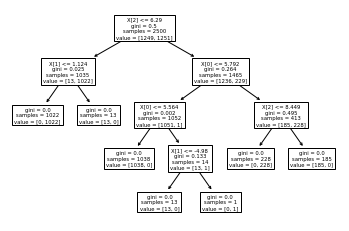

In [18]:
 tree.plot_tree(clf1);

# Evaluation

In both decision tree classifier implementation 3rd column i.e. c x[2] is considered to be the root node with threashold 
value around 6.29 for both of them.This results shows us high accuracy and is good sign of perfect implementation. Gini impurity is 0.5 in both the case.
The only change I see in implementation is that I could not dind a direct connection between gini impurity and entropy. So,
in MyDecisionTreeClassifier I have equated the entropy but not used it in my implementation.

### Question 2: Random Forest Classifier
- A simle RF implementation (10 pts)
    - make a bootstrap baggin function to make 3 samples.
    - for each sample, run a simple DT from question 1.
    - then average the accuracy. 
- Classification using RandomForestClassifier (5 pts)
- Evaluation (5 pts)

In [19]:
from sklearn.model_selection import train_test_split
x = df[['a','b','c']].values
y = df['class'].values.reshape(-1,1)

In [20]:
import random
def generate_sample(X,y,sample_ratio = 1.0):
    X_sample = []
    y_sample = []
    X_len = len(X)
    n_sample = X_len * 0.6
    while len(X_sample) < n_sample:
        index = random.randrange(X_len)
        X_sample.append(X[index,:])
        y_sample.append(y[index])
    return np.array(X_sample,dtype=np.int64),np.array(y_sample,dtype=np.int64)

In [21]:
X_1,y_1 = generate_sample(X,y,.6) #sample set 1
X_2,y_2 = generate_sample(X,y,.6) #sample set 2
X_3,y_3 = generate_sample(X,y,.6) #sample set 3

In [22]:
tree_1 = MyDecisionTreeClassifier()
tree_1.fit(X_1,y_1)
# tree_1.print_tree()
# Sir you can visualize tree of all 3 sample set if you uncomment the  

tree_2 = MyDecisionTreeClassifier()
tree_2.fit(X_2,y_2)
# tree_2.print_tree()

tree_3 = MyDecisionTreeClassifier()
tree_3.fit(X_3,y_3)
# tree_3.print_tree()

In [23]:
y_1_pred = tree_1.predict(X) 
acc_1 = accuracy_score(y, y_1_pred)
print("Accuracy for first tree:",acc_1*100)

y_2_pred = tree_2.predict(X) 
acc_2 = accuracy_score(y, y_2_pred)
print("Accuracy for second tree:",acc_2*100)

y_3_pred = tree_3.predict(X) 
acc_3 = accuracy_score(y, y_3_pred)
print("Accuracy for third tree:",acc_3*100)

print("Average Accuracy:",np.mean(np.array([acc_1,acc_2,acc_3]))*100)

Accuracy for first tree: 95.48
Accuracy for second tree: 95.48
Accuracy for third tree: 95.48
Average Accuracy: 95.48


# Sklearn

In [24]:
clf2 = RandomForestClassifier(n_estimators=3, max_depth=3,random_state=0) 

clf2.fit(X, y)
y_pred = clf2.predict(X)

In [25]:
print("Accuracy:",metrics.accuracy_score(y, y_pred)*100)

Accuracy: 100.0


In [26]:
#pip install graphviz

In [27]:
len(clf2.estimators_)

3

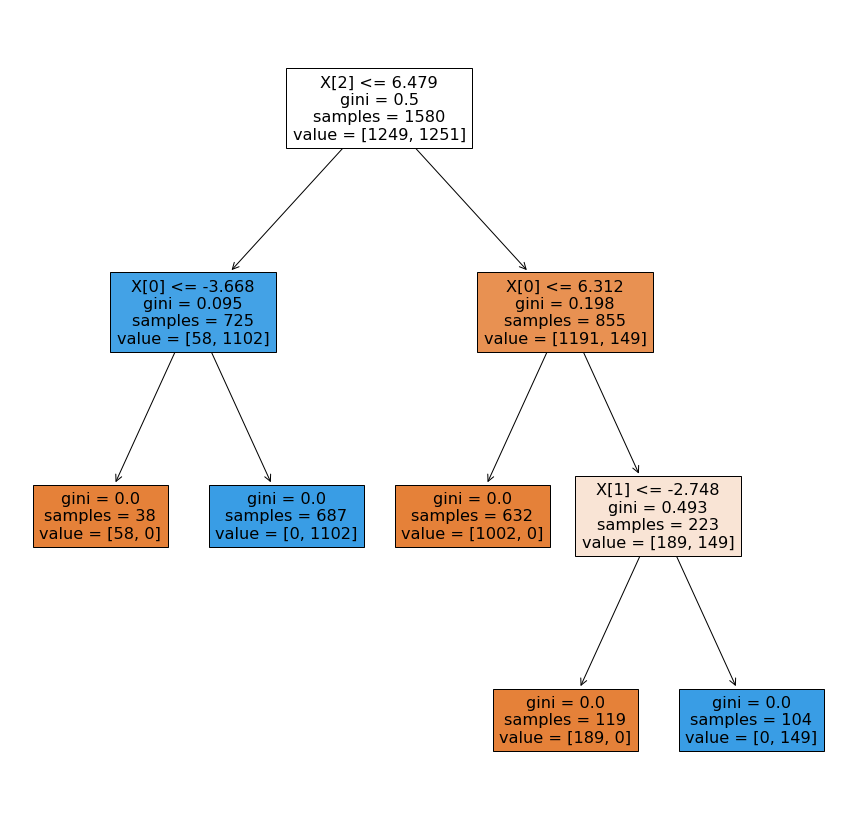

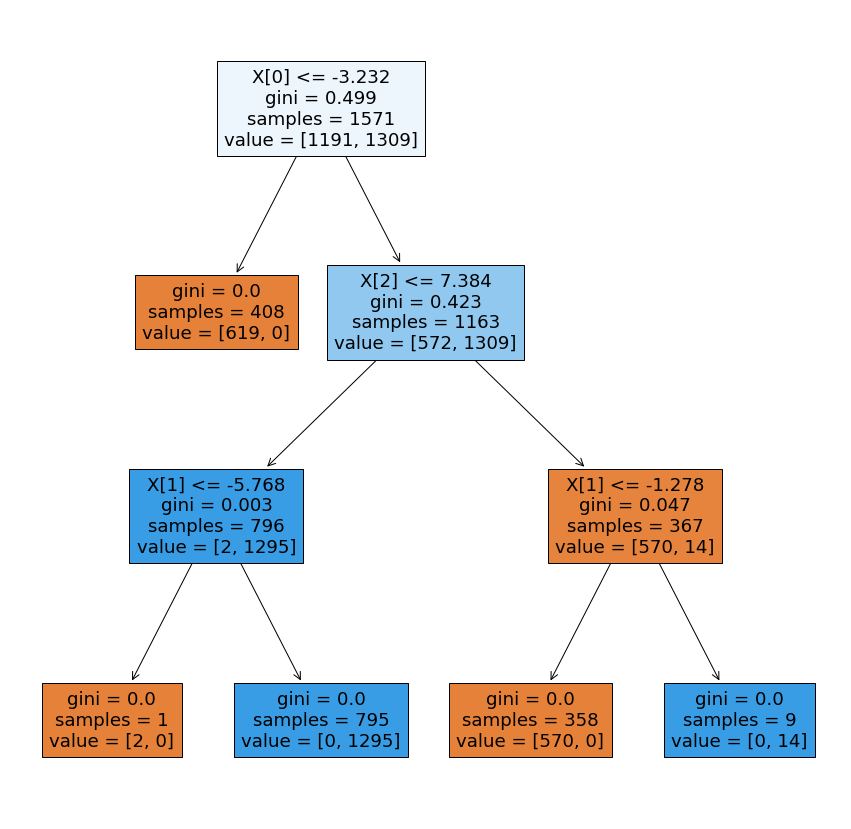

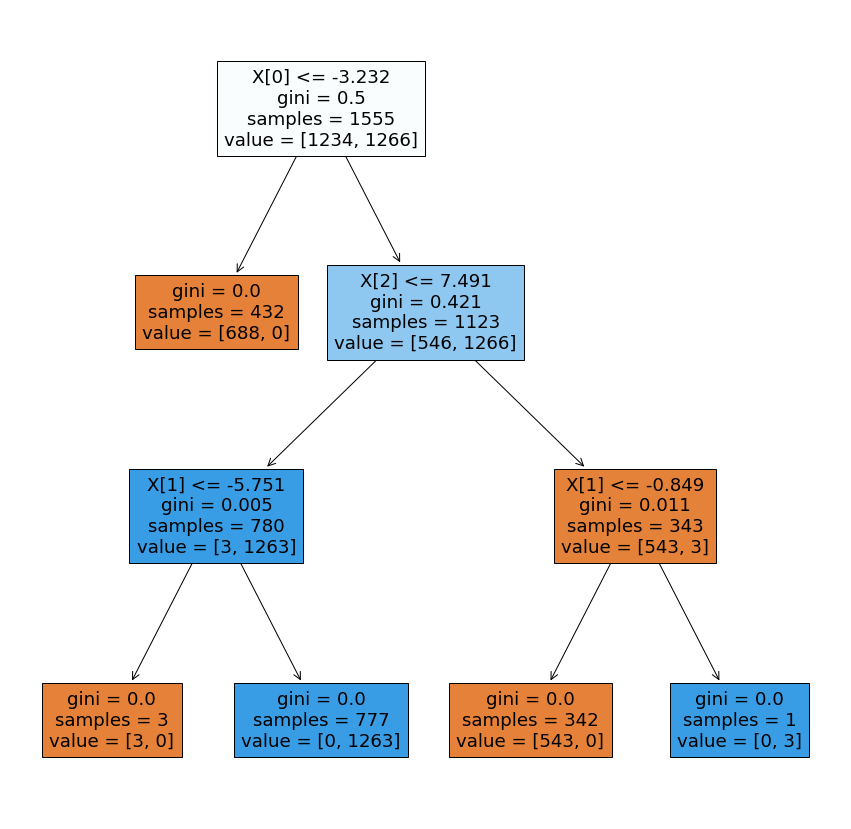

In [28]:
# clf2.estimators_[1]
for i in range(len(clf2.estimators_)):
        plt.figure(figsize = (15,15))
        tree.plot_tree(clf2.estimators_[i] , filled =True)
        plt.show()

# Evaluation

In my implementation I have created a generate_samplewhich is a bootstrap baggin function to make 3 samples as instructed 
question. This fuction works perfectly and we get a hifg accuracy on all the three samples as we have called MyDecisionTreeClassifier
from the above implementation. The reason why all the 3 trees give same accuracy because we have not split the data into train
and test. The average accuracy is 95.48 which is very good considering we build it from scratch.

### Question 3: AdaBoost Classifier
- AB implementation (15 pts)
- Classification using AdaBoostClassifier (5 pts)
- Evaluation (5 pts)

In [29]:
df['sample weight'] = 1/(df.shape[0]) # associated each sample with a sample weight

In [30]:
df.head()

,a,b,c,class,sample weight
0,9.4202,-4.3507,10.3764,1,0.0004
1,9.7044,-4.4601,10.6803,1,0.0004
2,9.8075,-4.0894,10.6259,1,0.0004
3,9.2771,-4.0349,10.1166,1,0.0004
4,9.6447,-3.5968,10.2936,1,0.0004


In [31]:
random.seed(10)
df1 = df.sample(len(df), replace = True, weights = df['sample weight'])

In [32]:
df1.head()

,a,b,c,class,sample weight
2327,-3.03540,-1.0889,3.2248,2,0.0004
1184,-4.68970,4.5872,6.5602,1,0.0004
2144,-1.75300,-2.5986,3.1346,2,0.0004
1906,0.45005,-4.2945,4.3180,2,0.0004
2115,-1.25690,-3.3204,3.5503,2,0.0004


In [33]:
from sklearn.model_selection import train_test_split
x = df[['a','b','c']]
y = df['class']

In [34]:
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=1)
clf3 = clf_gini.fit(x, y)

[Text(167.4, 163.07999999999998, 'X[2] <= 6.29\ngini = 0.5\nsamples = 2500\nvalue = [1249, 1251]'),
 Text(83.7, 54.360000000000014, 'gini = 0.025\nsamples = 1035\nvalue = [13, 1022]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.264\nsamples = 1465\nvalue = [1236, 229]')]

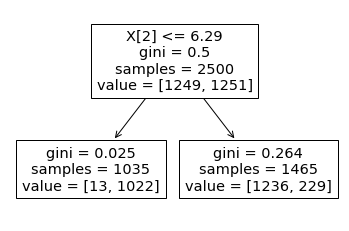

In [35]:
tree.plot_tree(clf3)

In [36]:
y_pred = clf_gini.predict(X)

In [37]:
df['pred1'] = y_pred

In [38]:
df

,a,b,c,class,sample weight,pred1
0,9.4202,-4.35070,10.3764,1,0.0004,1
1,9.7044,-4.46010,10.6803,1,0.0004,1
2,9.8075,-4.08940,10.6259,1,0.0004,1
3,9.2771,-4.03490,10.1166,1,0.0004,1
4,9.6447,-3.59680,10.2936,1,0.0004,1
...,...,...,...,...,...,...
2495,-2.3611,0.25915,2.3753,2,0.0004,2
2496,-2.6091,0.29695,2.6259,2,0.0004,2
2497,-2.7131,0.24234,2.7239,2,0.0004,2
2498,-3.0334,0.79411,3.1356,2,0.0004,2


In [39]:
df.loc[df['class'] != df.pred1, 'misclassified'] = 1
df.loc[df['class'] == df.pred1, 'misclassified'] = 0

In [40]:
e1 = sum(df['misclassified'] * df['sample weight'])
e1

0.09679999999999964

In [41]:
alpha1 = 0.5*np.log((1-e1)/e1)
alpha1

1.1166485092764624

In [42]:
new_weight = df['sample weight']*np.exp(-1*alpha1*df['class']*df['pred1'])

In [43]:
z = sum(new_weight)
normalized_weight = new_weight/sum(new_weight)

In [44]:
df['prob2'] = round(normalized_weight,4)

In [45]:
df

,a,b,c,class,sample weight,pred1,misclassified,prob2
0,9.4202,-4.35070,10.3764,1,0.0004,1,0.0,0.0007
1,9.7044,-4.46010,10.6803,1,0.0004,1,0.0,0.0007
2,9.8075,-4.08940,10.6259,1,0.0004,1,0.0,0.0007
3,9.2771,-4.03490,10.1166,1,0.0004,1,0.0,0.0007
4,9.6447,-3.59680,10.2936,1,0.0004,1,0.0,0.0007
...,...,...,...,...,...,...,...,...
2495,-2.3611,0.25915,2.3753,2,0.0004,2,0.0,0.0000
2496,-2.6091,0.29695,2.6259,2,0.0004,2,0.0,0.0000
2497,-2.7131,0.24234,2.7239,2,0.0004,2,0.0,0.0000
2498,-3.0334,0.79411,3.1356,2,0.0004,2,0.0,0.0000


In [46]:
#round 2
random.seed(20)
df2 = df.iloc[:,0:5]
df2 = df.sample(len(df), replace = True, weights = df['prob2'])
df2.head()

,a,b,c,class,sample weight,pred1,misclassified,prob2
776,-6.01850,-3.4243,6.9245,1,0.0004,1,0.0,0.0007
528,-2.76670,-7.0766,7.5982,1,0.0004,1,0.0,0.0007
416,-0.30538,-8.2808,8.2864,1,0.0004,1,0.0,0.0007
344,2.03630,-8.4298,8.6723,1,0.0004,1,0.0,0.0007
412,0.44994,-8.6344,8.6461,1,0.0004,1,0.0,0.0007


In [47]:
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=1)
clf = clf_gini.fit(X, y)

In [48]:
y_pred = clf_gini.predict(df.iloc[0:len(df),0:3])
#adding a column pred2 after the second round of boosting
df['pred2'] = y_pred

In [49]:
df.loc[df['class'] != df.pred2, 'misclassified2'] = 1
df.loc[df['class'] == df.pred2, 'misclassified2'] = 0


In [50]:
e2 = sum(df['misclassified2'] * df['prob2'])
e2

0.04839999999999982

In [51]:
alpha2 = 0.5*np.log((1-e2)/e2)
alpha2

1.4893224823531104

In [52]:
new_weight = df['prob2']*np.exp(-1*alpha2*df['class']*df['prob2'])
z = sum(new_weight)
normalized_weight = new_weight/sum(new_weight)

In [53]:
df['prob3'] = round(normalized_weight,3)

In [54]:
random.seed(30)
df3 = df.sample(len(df), replace = True, weights = df['prob3'])
df3 = df3.iloc[:,0:5]
# X_train = df3.iloc[0:len(iris),0:4]
# y_train = df3.iloc[0:len(iris),4]

clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=1)
clf = clf_gini.fit(x, y)

#adding a column pred3 after the third round of boosting
y_pred = clf_gini.predict(df.iloc[0:len(df),0:3])
df['pred3'] = y_pred

In [55]:
df

,a,b,c,class,sample weight,pred1,misclassified,prob2,pred2,misclassified2,prob3,pred3
0,9.4202,-4.35070,10.3764,1,0.0004,1,0.0,0.0007,1,0.0,0.001,1
1,9.7044,-4.46010,10.6803,1,0.0004,1,0.0,0.0007,1,0.0,0.001,1
2,9.8075,-4.08940,10.6259,1,0.0004,1,0.0,0.0007,1,0.0,0.001,1
3,9.2771,-4.03490,10.1166,1,0.0004,1,0.0,0.0007,1,0.0,0.001,1
4,9.6447,-3.59680,10.2936,1,0.0004,1,0.0,0.0007,1,0.0,0.001,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2495,-2.3611,0.25915,2.3753,2,0.0004,2,0.0,0.0000,2,0.0,0.000,2
2496,-2.6091,0.29695,2.6259,2,0.0004,2,0.0,0.0000,2,0.0,0.000,2
2497,-2.7131,0.24234,2.7239,2,0.0004,2,0.0,0.0000,2,0.0,0.000,2
2498,-3.0334,0.79411,3.1356,2,0.0004,2,0.0,0.0000,2,0.0,0.000,2


In [56]:
df.loc[df['class'] != df.pred3, 'misclassified3'] = 1
df.loc[df['class'] == df.pred3, 'misclassified3'] = 0

For the round 3 it shows that there are no misclassified, so I have commented the code for finding the value for third 
iteration i.e e3, alpha3 and so on.
Sir,You can check if for yourself.

In [57]:
# e3 = sum(df['misclassified3'] * df['prob3']) #/len(example)
# e3

In [58]:
# alpha3 = 0.5*np.log((1-e3)/e3)
# alpha3

In [59]:
# new_weight = df['prob3']*np.exp(-1*alpha3*df['class']*df['pred3'])
# z = sum(new_weight)
# normalized_weight = new_weight/sum(new_weight)

In [60]:
# df['prob4'] = round(normalized_weight,4)

In [61]:
t = alpha1 * df['pred1'] + alpha2 * df['pred2'] #+ alpha3 * df['pred3'] 
np.sign(list(t))

array([1., 1., 1., ..., 1., 1., 1.])

In [62]:
df['final_pred'] = np.sign(list(t))
df

,a,b,c,class,sample weight,pred1,misclassified,prob2,pred2,misclassified2,prob3,pred3,misclassified3,final_pred
0,9.4202,-4.35070,10.3764,1,0.0004,1,0.0,0.0007,1,0.0,0.001,1,0.0,1.0
1,9.7044,-4.46010,10.6803,1,0.0004,1,0.0,0.0007,1,0.0,0.001,1,0.0,1.0
2,9.8075,-4.08940,10.6259,1,0.0004,1,0.0,0.0007,1,0.0,0.001,1,0.0,1.0
3,9.2771,-4.03490,10.1166,1,0.0004,1,0.0,0.0007,1,0.0,0.001,1,0.0,1.0
4,9.6447,-3.59680,10.2936,1,0.0004,1,0.0,0.0007,1,0.0,0.001,1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,-2.3611,0.25915,2.3753,2,0.0004,2,0.0,0.0000,2,0.0,0.000,2,0.0,1.0
2496,-2.6091,0.29695,2.6259,2,0.0004,2,0.0,0.0000,2,0.0,0.000,2,0.0,1.0
2497,-2.7131,0.24234,2.7239,2,0.0004,2,0.0,0.0000,2,0.0,0.000,2,0.0,1.0
2498,-3.0334,0.79411,3.1356,2,0.0004,2,0.0,0.0000,2,0.0,0.000,2,0.0,1.0


In [63]:
c=confusion_matrix(df['class'], df['final_pred'])
c

array([[1249,    0],
       [1251,    0]], dtype=int64)

In [64]:
(c[0,0]+c[1,1])/np.sum(c)*100

49.96

# Sklearn

In [65]:
x = df[['a','b','c']]
y = df['class']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [67]:
ada = AdaBoostClassifier(n_estimators=50,learning_rate=1)

model = ada.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [68]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)*100)

Accuracy: 99.33333333333333


[Text(167.4, 163.07999999999998, 'X[2] <= 7.474\ngini = 0.5\nsamples = 1750\nvalue = [0.5, 0.5]'),
 Text(83.7, 54.360000000000014, 'gini = 0.385\nsamples = 1273\nvalue = [0.174, 0.495]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.028\nsamples = 477\nvalue = [0.326, 0.005]')]

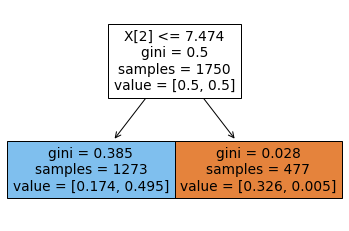

In [69]:
tree.plot_tree(ada.estimators_[i] , filled =True)

# Evaluation

For the AdaBoostClassifier I have taken step by step approch rather than building a class. I could definitely increase the accuracy of my implementation as it is only 49%. I think I made some mistake while calculating e3 as mentioned above the misclassified3 which might be wrong. I can improve my accuracy by goving with more traditional approch of building the class and iterating using for loop.

### Question 4: Gradient Boost Classifier
- GB implementation (15 pts)
- Classification using GradientBoostingClassifier (5 pts)
- Evaluation (5 pts)

In [70]:
df_gb = pd.read_csv('./F21_CS559_HW3_data.csv')
x = df_gb[['a','b','c']]
y = df_gb['class']

In [71]:
# df_gb['class'].value_counts() 

In [72]:
log_odds=np.log(1251/ 1249)
log_odds

0.0016000003413334314

In [73]:
prob=np.exp(log_odds)/(1+np.exp(log_odds))
prob

0.5004

In [74]:
predict=1
n_samples=4000

In [75]:
loss=-(y*np.log(prob)+(1-y)*np.log(1-prob))
loss

0       0.692348
1       0.692348
2       0.692348
3       0.692348
4       0.692348
          ...   
2495    0.690748
2496    0.690748
2497    0.690748
2498    0.690748
2499    0.690748
Name: class, Length: 2500, dtype: float64

In [76]:
df_gb['loss'] = loss
df_gb

,a,b,c,class,loss
0,9.4202,-4.35070,10.3764,1,0.692348
1,9.7044,-4.46010,10.6803,1,0.692348
2,9.8075,-4.08940,10.6259,1,0.692348
3,9.2771,-4.03490,10.1166,1,0.692348
4,9.6447,-3.59680,10.2936,1,0.692348
...,...,...,...,...,...
2495,-2.3611,0.25915,2.3753,2,0.690748
2496,-2.6091,0.29695,2.6259,2,0.690748
2497,-2.7131,0.24234,2.7239,2,0.690748
2498,-3.0334,0.79411,3.1356,2,0.690748


In [77]:
class MyGradientBoostingClassifier():
    def __init__(self):
        
        self.n_estimators=50
        self.learning_rate=0.5
        self.max_depth=3
        self.max_leaf_nodes=3
        
    def iteration():
        for i in range(10):
            residuals[i] = y - prob[i]

            dt = DecisionTreeRegressor(max_depth, max_leaf_nodes=3)
            dt=dt.fit(x, y)

            dt.find_better_split(0)

            r = np.where(xi == tree.split)[0][0]

            left_idx = np.where(xi <= tree.split)[0]  
            right_idx = np.where(xi > tree.split)[0]  
            trees.append(dt.tree_)
        

# Sklearn

In [78]:
x = df[['a','b','c']]
y = df['class']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [80]:
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=3, max_depth=3, random_state=0)
gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_test)

In [81]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)*100)

Accuracy: 99.86666666666667


In [82]:
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.25, max_features=3, max_depth=3, random_state=0)
gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_test)

In [83]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)*100)

Accuracy: 99.86666666666667


In [84]:
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=1, max_features=3, max_depth=3, random_state=0)
gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_test)

In [85]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)*100)

Accuracy: 99.86666666666667


# Evaluation

As we can see from above the as the learning rate changes accuracy also changes. In my implementation I have computed log of odds and prob for class MyGradientBoostingClassifier.